The Dataset contains the following 12 features:

CustomerID: A unique identifier

Age: The age of the customer

Gender: The gender of the customer

Tenure: The number of months the customer has stayed with the company

Usage Frequency: The number of times the customer has used the service the past month

Support calls: The number of support calls the customer has made the past month

Payment Delay: Number of days the customer has delayed payment the past month

Subscription Type: The type of subscription the customer has

Contract Length: Duration of the contract

Total Spend: The total amount the customer has spent

Last Interaction: Number of days since the last interaction the customer has had with the company

Churn: Whether the customer has churned or not

# Import packages

In [104]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

# Cleanup

In [53]:
test_set_dirty = pd.read_csv("Datasets/In/customer_churn_dataset-testing-master.csv", sep=",")
training_set_dirty = pd.read_csv("Datasets/In/customer_churn_dataset-training-master.csv", sep=",")

combined_set_dirty = pd.concat([training_set_dirty, test_set_dirty], ignore_index=True)
combined_set_dirty = combined_set_dirty.drop(combined_set_dirty.columns[0], axis=1)


In [54]:
missing_values = combined_set_dirty.isnull().sum()
missing_values

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [55]:
combined_set_dirty[combined_set_dirty.isna().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# remove row with missing values
combined_set_dirty.dropna(inplace=True)

combined_set_dirty.columns = [col.lower().replace(" ", "_") for col in combined_set_dirty.columns]
combined_set_dirty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505206 entries, 0 to 505206
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                505206 non-null  float64
 1   gender             505206 non-null  object 
 2   tenure             505206 non-null  float64
 3   usage_frequency    505206 non-null  float64
 4   support_calls      505206 non-null  float64
 5   payment_delay      505206 non-null  float64
 6   subscription_type  505206 non-null  object 
 7   contract_length    505206 non-null  object 
 8   total_spend        505206 non-null  float64
 9   last_interaction   505206 non-null  float64
 10  churn              505206 non-null  float64
dtypes: float64(8), object(3)
memory usage: 46.3+ MB


In [57]:
combined_set_dirty[combined_set_dirty.isna().any(axis=1)]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn


In [58]:
numerals = ["age", "tenure", "usage_frequency", "support_calls", "payment_delay", "last_interaction", "churn"]

for col in numerals:
    combined_set_dirty[col] = combined_set_dirty[col].astype(int)
    

In [59]:
# # Create a label encoder object
# le = LabelEncoder()
# 
# # List of columns you want to convert
# columns_to_convert = ['gender', 'subscription_type', 'contract_length']
# 
# # Apply the label encoder to each column and print the mapping
# for column in columns_to_convert:
#     combined_set_dirty[column] = le.fit_transform(combined_set_dirty[column])
#     print(f"Mapping for {column}:")
#     for class_, label in zip(le.classes_, range(len(le.classes_))):
#         print(f"{class_} -> {label}")
#     print("\n")

In [60]:
cleaned_set = combined_set_dirty.copy()

Descriptive Analytics

Summary Statistics for Churned Customers:
                 age         tenure  usage_frequency  support_calls  \
count  280492.000000  280492.000000    280492.000000  280492.000000   
mean       41.872841      31.021683        15.303909       5.281377   
std        13.988755      17.270441         8.737989       3.123577   
min        18.000000       1.000000         1.000000       0.000000   
25%        30.000000      16.000000         8.000000       3.000000   
50%        42.000000      31.000000        15.000000       5.000000   
75%        54.000000      46.000000        23.000000       8.000000   
max        65.000000      60.000000        30.000000      10.000000   

       payment_delay    total_spend  last_interaction     churn  
count  280492.000000  280492.000000     280492.000000  280492.0  
mean       15.991454     538.899354         15.590266       1.0  
std         8.985814     260.016780          8.655404       0.0  
min         0.000000     100.000000          1.000000 

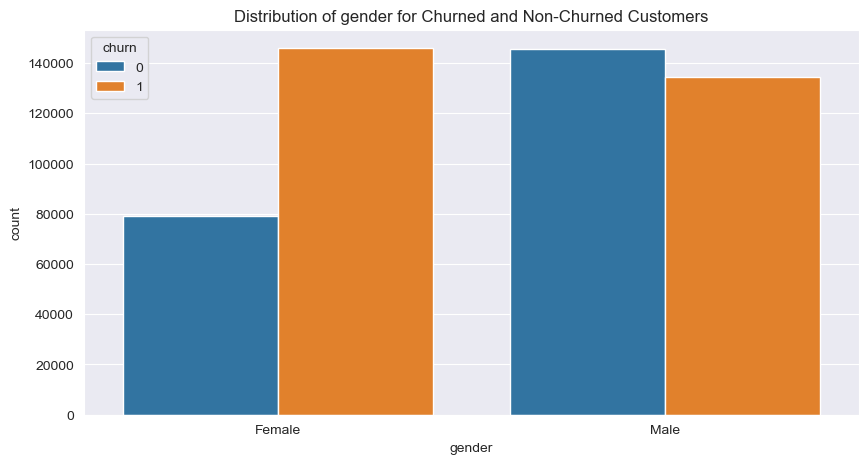

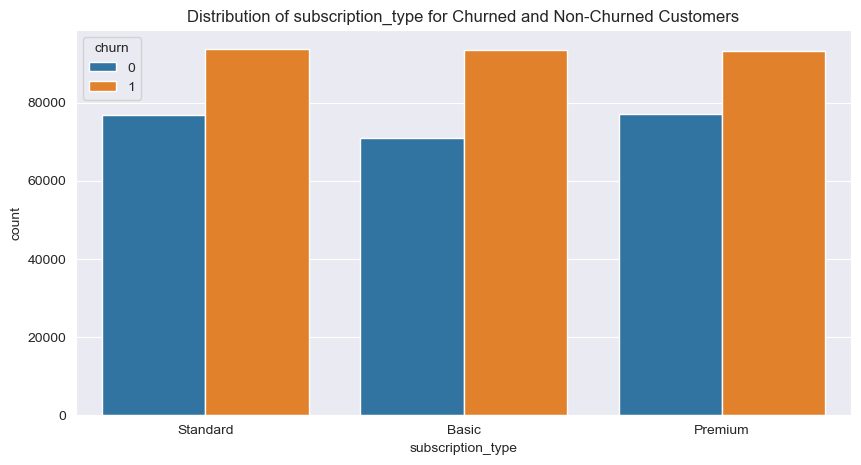

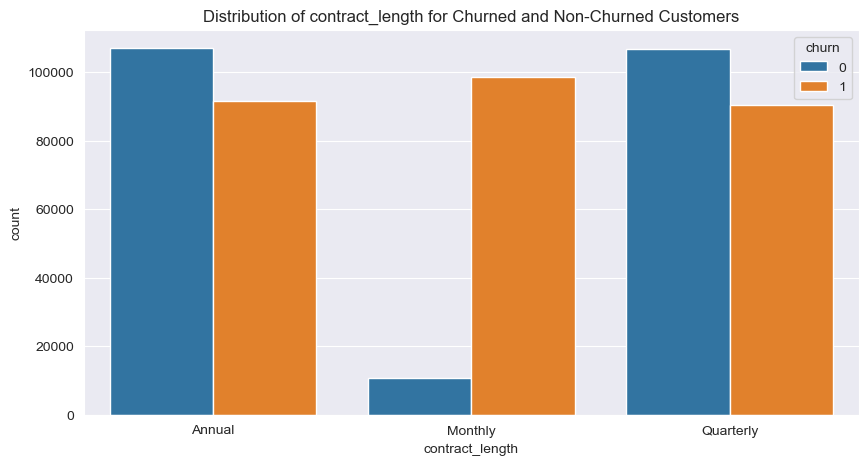

C:\Users\yusuf\AppData\Local\Temp\ipykernel_37152\3540273037.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = cleaned_set.corr()


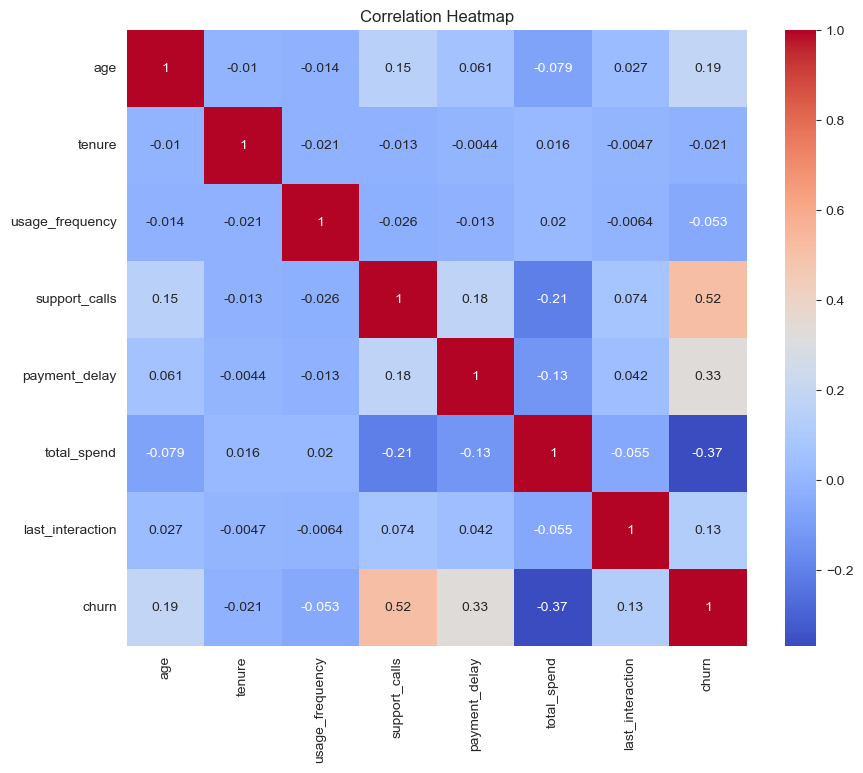

Churn Rate: 55.52032240313852%


In [61]:
# Summary statistics
print("Summary Statistics for Churned Customers:")
print(cleaned_set[cleaned_set['churn'] == 1].describe())
print("\nSummary Statistics for Non-Churned Customers:")
print(cleaned_set[cleaned_set['churn'] == 0].describe())

# Distribution of categorical variables
categorical_columns = ['gender', 'subscription_type', 'contract_length']
for column in categorical_columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=cleaned_set, x=column, hue='churn')
    plt.title(f'Distribution of {column} for Churned and Non-Churned Customers')
    plt.show()

# Correlation analysis
correlation = cleaned_set.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Churn rate
churn_rate = cleaned_set['churn'].mean() * 100
print(f"Churn Rate: {churn_rate}%")

In [62]:
numeric_cols = ["age", "tenure", "usage_frequency", "support_calls", "payment_delay", "last_interaction", "total_spend"]

num_bins = 3

excourse_set = cleaned_set.copy()

for col in numeric_cols:
    excourse_set[col] = pd.cut(cleaned_set[col], num_bins, duplicates='drop')
    print(col)
    for interval in excourse_set[col].cat.categories:
        print(interval)

age
(17.953, 33.667]
(33.667, 49.333]
(49.333, 65.0]
tenure
(0.941, 20.667]
(20.667, 40.333]
(40.333, 60.0]
usage_frequency
(0.971, 10.667]
(10.667, 20.333]
(20.333, 30.0]
support_calls
(-0.01, 3.333]
(3.333, 6.667]
(6.667, 10.0]
payment_delay
(-0.03, 10.0]
(10.0, 20.0]
(20.0, 30.0]
last_interaction
(0.971, 10.667]
(10.667, 20.333]
(20.333, 30.0]
total_spend
(99.1, 400.0]
(400.0, 700.0]
(700.0, 1000.0]


In [63]:
columns = ["age", "gender", "tenure", "usage_frequency", "support_calls", "payment_delay", "subscription_type", "contract_length", "total_spend", "last_interaction"]

stacked_data_percent = {}

for col in columns:
    category_counts = excourse_set.groupby([col, "churn"]).size().unstack(fill_value=0)
    
    category_percent = category_counts.div(category_counts.sum(axis=1), axis=0) * 100
    print(category_percent)
    stacked_data_percent[col] = category_percent
    

churn                     0          1
age                                   
(17.953, 33.667]  48.003985  51.996015
(33.667, 49.333]  57.166378  42.833622
(49.333, 65.0]    16.496744  83.503256
churn           0          1
gender                      
Female  35.105565  64.894435
Male    52.002869  47.997131
churn                     0          1
tenure                                
(0.941, 20.667]   43.067892  56.932108
(20.667, 40.333]  44.660109  55.339891
(40.333, 60.0]    45.557180  54.442820
churn                     0          1
usage_frequency                       
(0.971, 10.667]   40.165348  59.834652
(10.667, 20.333]  46.572919  53.427081
(20.333, 30.0]    46.431268  53.568732
churn                   0          1
support_calls                       
(-0.01, 3.333]  67.694781  32.305219
(3.333, 6.667]  24.752522  75.247478
(6.667, 10.0]    8.490178  91.509822
churn                  0          1
payment_delay                      
(-0.03, 10.0]  56.567156  43.432844
(10.0,

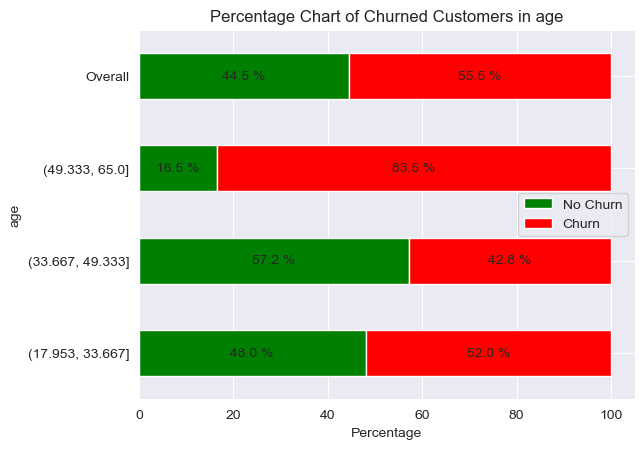

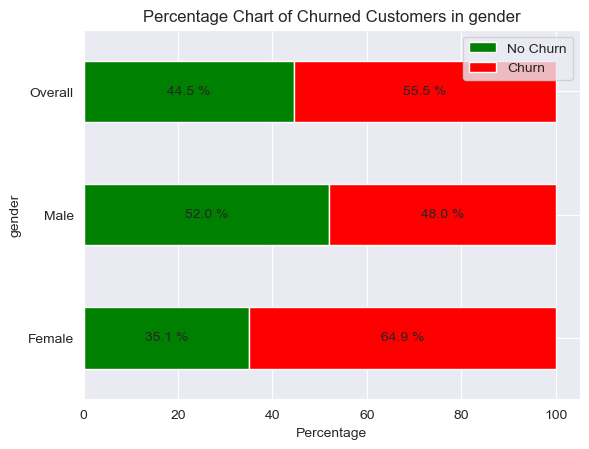

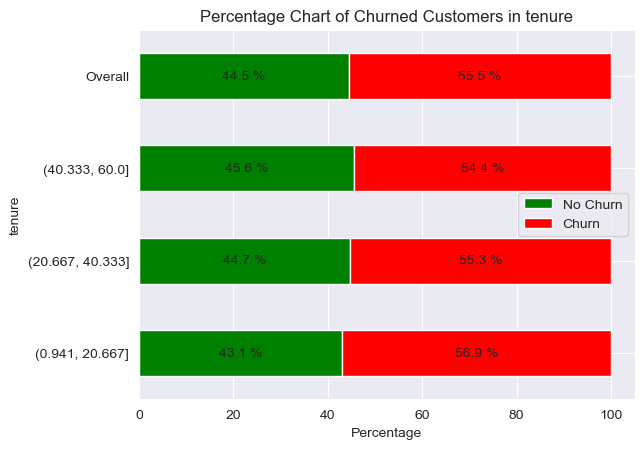

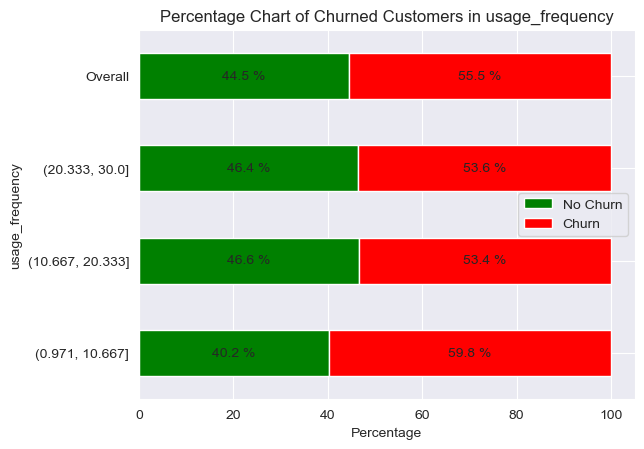

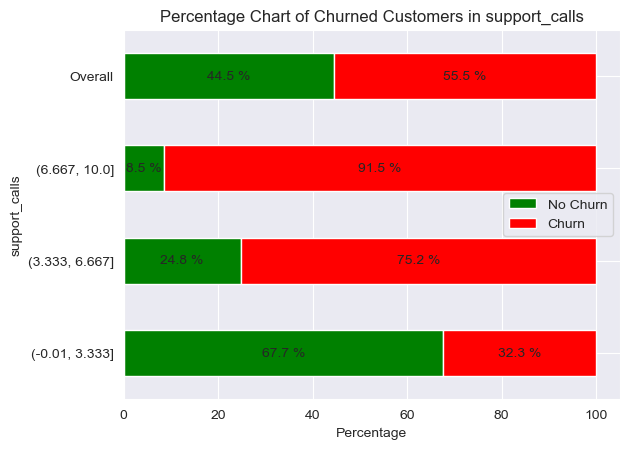

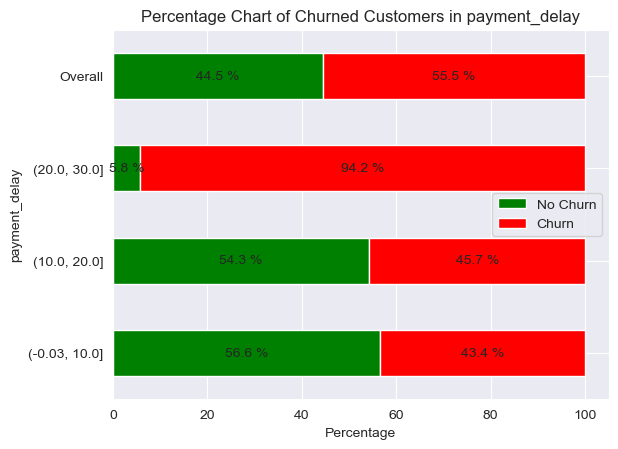

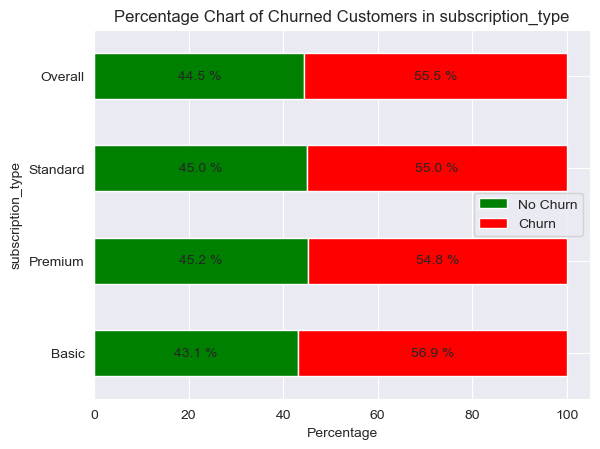

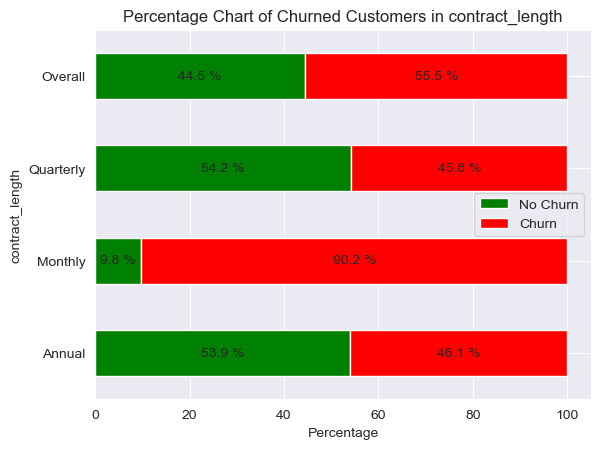

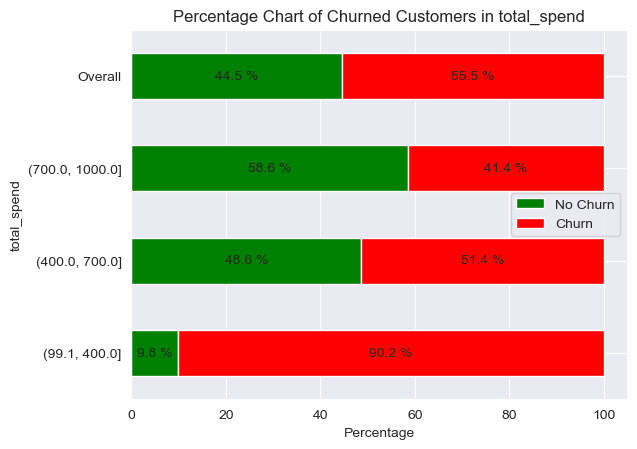

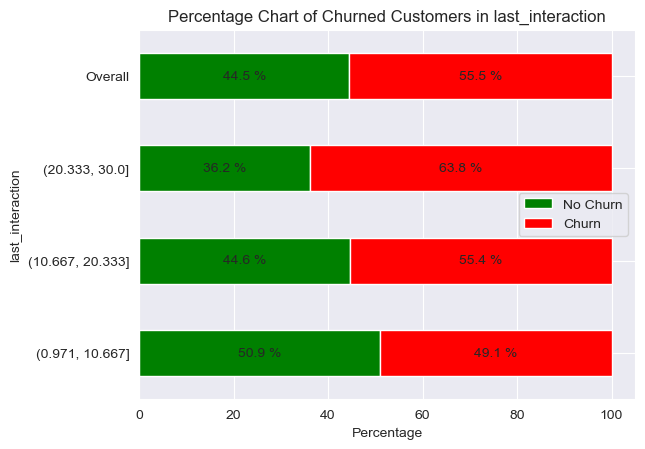

In [64]:
# Calculate the overall churn rate
overall_churn_rate = excourse_set['churn'].mean() * 100

# Add a new row to each DataFrame in stacked_data_percent with the overall churn rate
for col, df in stacked_data_percent.items():
    df.loc['Overall'] = [100 - overall_churn_rate, overall_churn_rate]
    
colors = {0: 'green', 1: 'red'}
for col, df in stacked_data_percent.items():
    ax = df.plot(kind='barh', stacked=True, color=[colors[churn] for churn in df.columns],
                 title=f'Percentage Chart of Churned Customers in {col}')
    plt.ylabel(col)
    plt.xlabel('Percentage')
    plt.legend(["No Churn", "Churn"], loc='best')

    # Add the percentage values on each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.text(x+width/2,
                y+height/2,
                '{:.1f} %'.format(width),
                horizontalalignment='center',
                verticalalignment='center')
    plt.show()

In [65]:
combinations = list(itertools.combinations(columns, 2))

# Analyze each combination
for combination in combinations:
    # Create a multi-index DataFrame
    multi_index_df = excourse_set.set_index(list(combination) + ['churn'])

    # Calculate the size of each group
    grouped_df = multi_index_df.groupby(list(combination) + ['churn']).size()

    # Unstack the DataFrame to get a cross-tabulation
    cross_tab = grouped_df.unstack(fill_value=0)

    # Convert absolute numbers to relative percentages
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

    # Print the cross-tabulation
    print(f"Cross-tabulation for {combination}:")
    print(cross_tab_percent)
    print("\n")

Cross-tabulation for ('age', 'gender'):
churn                            0          1
age              gender                      
(17.953, 33.667] Female  38.025946  61.974054
                 Male    55.880714  44.119286
(33.667, 49.333] Female  46.674686  53.325314
                 Male    64.828696  35.171304
(49.333, 65.0]   Female  13.456105  86.543895
                 Male    19.450720  80.549280


Cross-tabulation for ('age', 'tenure'):
churn                                      0          1
age              tenure                                
(17.953, 33.667] (0.941, 20.667]   46.438193  53.561807
                 (20.667, 40.333]  48.112829  51.887171
                 (40.333, 60.0]    49.270641  50.729359
(33.667, 49.333] (0.941, 20.667]   55.417985  44.582015
                 (20.667, 40.333]  57.593139  42.406861
                 (40.333, 60.0]    58.264728  41.735272
(49.333, 65.0]   (0.941, 20.667]   17.309815  82.690185
                 (20.667, 40.333]  16.208328  

In [66]:
combinations = list(itertools.combinations(columns, 3))

# Analyze each combination
for combination in combinations:
    # Create a multi-index DataFrame
    multi_index_df = excourse_set.set_index(list(combination) + ['churn'])

    # Calculate the size of each group
    grouped_df = multi_index_df.groupby(list(combination) + ['churn']).size()

    # Unstack the DataFrame to get a cross-tabulation
    cross_tab = grouped_df.unstack(fill_value=0)

    # Convert absolute numbers to relative percentages
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

    # Print the cross-tabulation
    print(f"Cross-tabulation for {combination}:")
    print(cross_tab_percent)
    print("\n")

Cross-tabulation for ('age', 'gender', 'tenure'):
churn                                             0          1
age              gender tenure                                
(17.953, 33.667] Female (0.941, 20.667]   36.304143  63.695857
                        (20.667, 40.333]  38.302639  61.697361
                        (40.333, 60.0]    39.308211  60.691789
                 Male   (0.941, 20.667]   54.665294  45.334706
                        (20.667, 40.333]  55.839340  44.160660
                        (40.333, 60.0]    56.960874  43.039126
(33.667, 49.333] Female (0.941, 20.667]   44.749403  55.250597
                        (20.667, 40.333]  47.076472  52.923528
                        (40.333, 60.0]    47.990544  52.009456
                 Male   (0.941, 20.667]   63.435513  36.564487
                        (20.667, 40.333]  65.198525  34.801475
                        (40.333, 60.0]    65.654152  34.345848
(49.333, 65.0]   Female (0.941, 20.667]   14.137621  85.862379
     

# Predictive Analytics
## Primitive Approach

In [67]:
prepared_set = cleaned_set.copy()

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False)

# Identify categorical columns
categorical_cols = ['gender', 'subscription_type', 'contract_length']

# Fit and transform the data, converting it into a DataFrame
prepared_set_encoded = pd.DataFrame(encoder.fit_transform(prepared_set[categorical_cols]))

# Get feature names from the encoder and assign them as column names
prepared_set_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Drop the original categorical columns
prepared_set.drop(categorical_cols, axis=1, inplace=True)

# Reset the indices of the dataframes
prepared_set = prepared_set.reset_index(drop=True)
prepared_set_encoded = prepared_set_encoded.reset_index(drop=True)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
prepared_set = pd.concat([prepared_set, prepared_set_encoded], axis=1)

prepared_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505206 entries, 0 to 505205
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         505206 non-null  int32  
 1   tenure                      505206 non-null  int32  
 2   usage_frequency             505206 non-null  int32  
 3   support_calls               505206 non-null  int32  
 4   payment_delay               505206 non-null  int32  
 5   total_spend                 505206 non-null  float64
 6   last_interaction            505206 non-null  int32  
 7   churn                       505206 non-null  int32  
 8   gender_Female               505206 non-null  float64
 9   gender_Male                 505206 non-null  float64
 10  subscription_type_Basic     505206 non-null  float64
 11  subscription_type_Premium   505206 non-null  float64
 12  subscription_type_Standard  505206 non-null  float64
 13  contract_lengt

In [68]:
primitive_set = prepared_set.copy()

X = primitive_set.drop('churn', axis=1)
y = primitive_set['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [69]:
# Calculate the performance metrics

# Predict the probabilities of the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]


primitive_mse = mean_squared_error(y_test, y_pred)
primitive_mae = mean_absolute_error(y_test, y_pred)
primitive_r2 = r2_score(y_test, y_pred)
primitive_accuracy = accuracy_score(y_test, y_pred)
primitive_precision = precision_score(y_test, y_pred)
primitive_recall = recall_score(y_test, y_pred)
primitive_f1 = f1_score(y_test, y_pred)
primitive_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"MSE: {primitive_mse}\nMAE: {primitive_mae}\nR2: {primitive_r2}\nAccuracy: {primitive_accuracy}\nPrecision: {primitive_precision}\nRecall: {primitive_recall}\nF1 Score: {primitive_f1}\nROC AUC: {primitive_roc_auc}")

MSE: 0.15392609014073355
MAE: 0.15392609014073355
R2: 0.3768018443702186
Accuracy: 0.8460739098592664
Precision: 0.8717967545341068
Recall: 0.8471486416581937
F1 Score: 0.8592959823407545
ROC AUC: 0.9068711030711689


# My Model

### Define Target and Feauture Variables & Split and Scale Set
Split the data into training, validation, and test sets, then, standardise the features

In [100]:
better_model = prepared_set.copy()

# Define Target and feature variables
y = better_model['churn'].values
X = better_model.drop(['churn'], axis=1)

# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

### Train and Evaluate Models
Perform hyperparameter tuning for the LightGBM using grid search. Print the best hyperparameters and the corresponding R-squared(on subset of training set(Cross-Validation)) score.

In [102]:
# Define the parameter lgbm_grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
lgbm_model = lgb.LGBMRegressor()

# Create the lgbm_grid search object
lgbm_grid = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='r2')

# Fit the lgbm_grid search object to the data
lgbm_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 31}
0.781253421858889


Perform hyperparameter tuning for the Decision Tree model using grid search. Print the best hyperparameters and the corresponding R-squared(on subset of training set(Cross-Validation)) score

In [105]:
# Define the parameter tree_grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
decTree_model = DecisionTreeRegressor()

#Create the tree_grid search object
tree_grid = GridSearchCV(decTree_model, param_grid, cv=5, scoring="r2")

# fit the tree_grid search object to the data
tree_grid.fit(X_train, y_train)

#Print the best parameters and the corresponding score
print(tree_grid.best_params_)
print(tree_grid.best_score_)

{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.7680010232614064


Comparison of Mean Squared Error
Decision Tree: 0.05825114625460266
LightGBM: 0.05532667672276414
Comparison of R2 Score
Decision Tree: 0.7641330734297667
LightGBM: 0.7759746539766651
Comparison of Mean Absolute Error
Decision Tree: 0.11246073891250782
LightGBM: 0.11354909129077033


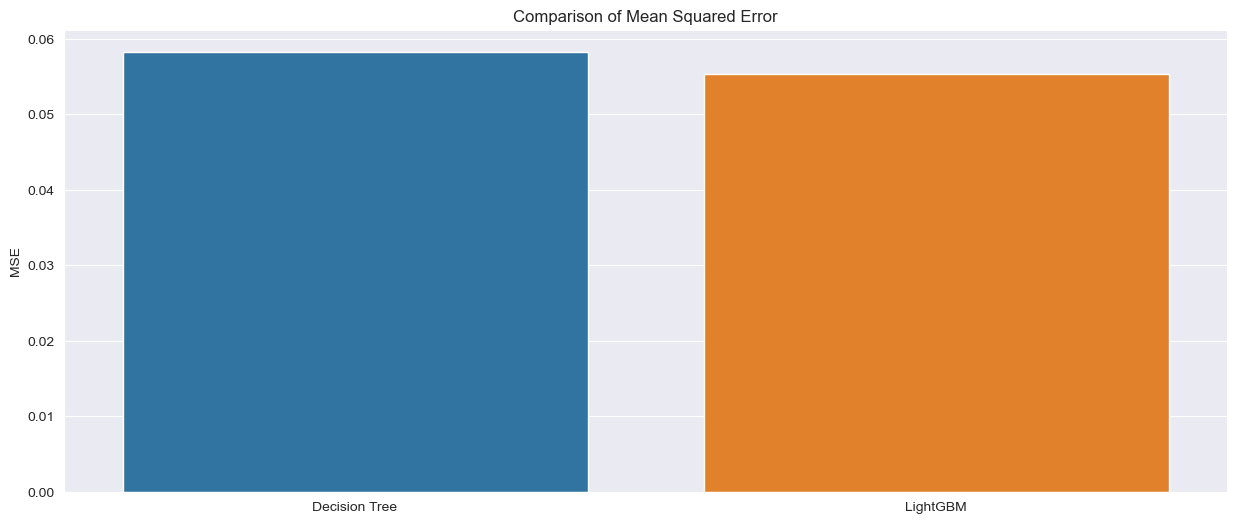

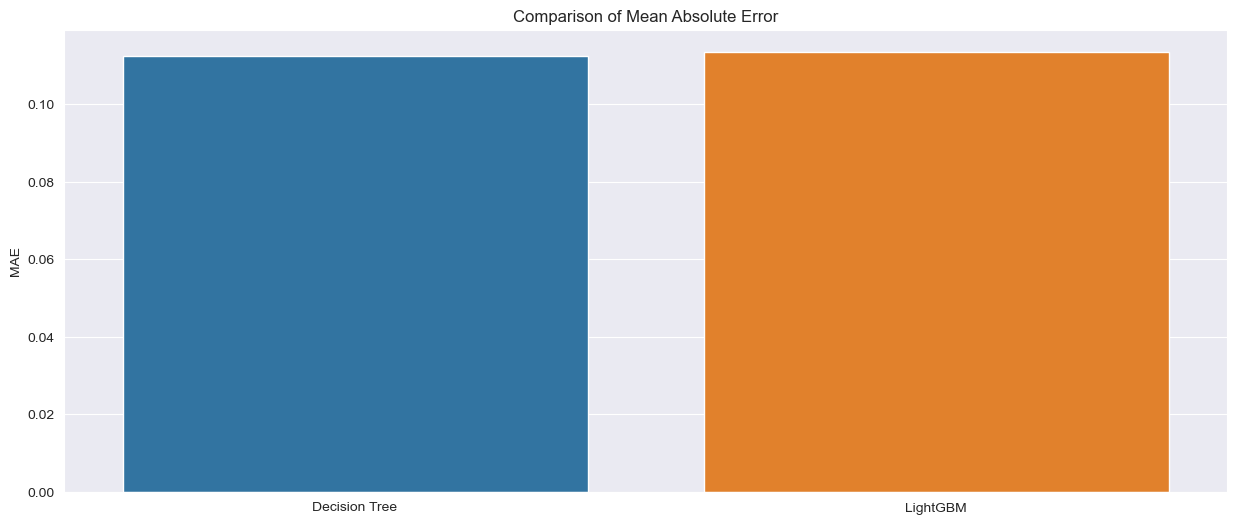

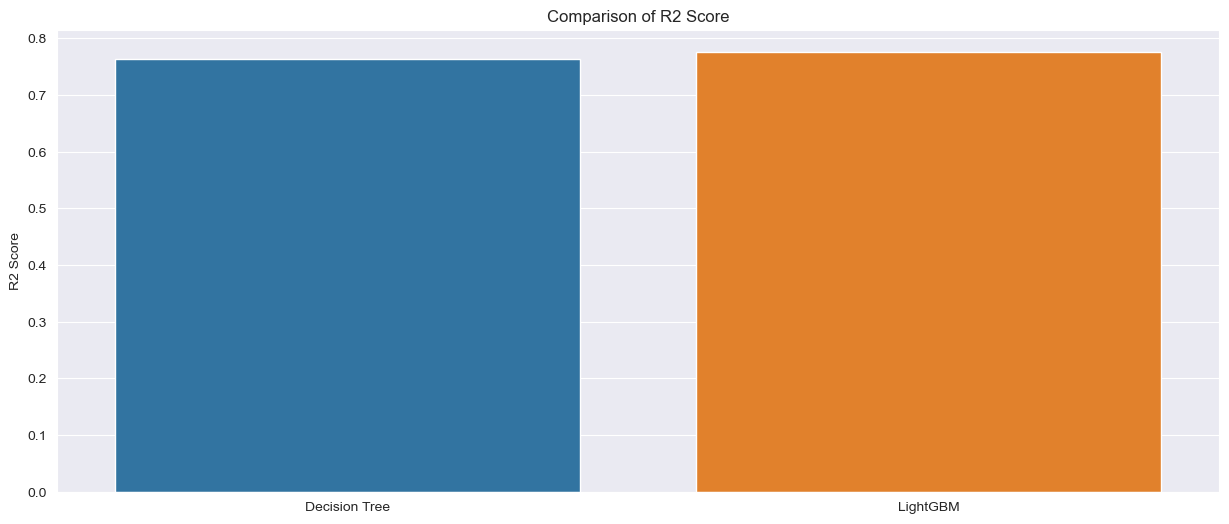

In [110]:
y_pred_tree = tree_grid.best_estimator_.predict(X_val)
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)
r2_tree = r2_score(y_val, y_pred_tree)
mse_lgbm = mean_squared_error(y_val, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_val, y_pred_lgbm)
r2_lgbm = r2_score(y_val, y_pred_lgbm)

models = ['Decision Tree', 'LightGBM']
mse_values = [mse_tree, mse_lgbm]
mae_values = [mae_tree, mae_lgbm]
r2_values = [r2_tree, r2_lgbm]

# Function to print the values
def print_values(values, models, title):
    print(title)
    for model, value in zip(models, values):
        print(f"{model}: {value}")

# Function to plot the values
def plot_values(values, title, models, ylabel):
    plt.figure(figsize=(15, 6))
    sns.barplot(x=models, y=values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

# Print and plot MSE values
print_values(mse_values, models, 'Comparison of Mean Squared Error')
print_values(r2_values, models, 'Comparison of R2 Score')
print_values(mae_values, models, 'Comparison of Mean Absolute Error')
plot_values(mse_values, 'Comparison of Mean Squared Error', models, 'MSE')

# Print and plot MAE values

plot_values(mae_values, 'Comparison of Mean Absolute Error', models, 'MAE')

# Print and plot R2 values

plot_values(r2_values, 'Comparison of R2 Score', models, 'R2 Score')